### Napovedovanje okužb
Naloge se lotim z nevronskimi mrežami. Vhodna plast je velikosti N, izhodna velikosti M. 

Obliko mreže bomo izbrali s pomočjo algoritmov za hiperoptimizacijo. 

In [1]:
import pandas as pd
import torch
from torch.nn.functional import normalize
import numpy as np

In [2]:
from prepeare_data import transform_data
data = pd.read_csv('okuzeni.csv')
n_obcin = data.shape[1]
data.head()

MESTNE_OBCINE = [
'ljubljana',
'maribor',
'kranj',
'koper',
'celje',
'novo_mesto',
'velenje',
'nova_gorica',
'krško',
'ptuj',
'murska_sobota',
'slovenj_gradec'
]
N_MESTNIH_OBCIN = len(MESTNE_OBCINE)



Imamo podatke za vseh 192 občin. Mnogo podatkov manjka. Prav tako mislim, da ne potrebujemo upoštevati vseh občin. 

Odločil sem se, da bom občine z več kot 50imi manjkajočimi vrednosti odstranil iz analize, pri ostalih pa bom manjkajoče vrednosti interpoliral glede na sosednje dni

In [3]:
n_nan = data.isna().sum()
#n_nan.plot()
print( "Število odstranjenih občin:" , len(n_nan[n_nan > 50]))
# odstranimo "slabe" obcine
obcine = set(data.columns) - set(n_nan[n_nan > 50].index)
obcine = list(obcine)
n_obcin = len(obcine)

#nismo odstranili slabih:
#>>> for o in MESTNE_OBCINE:
#        print(o in obcine)
#True

# posodobimo podatke

data = data[obcine]
# interpolacija vzdolž stolpcev:
data = data.interpolate(axis=1)
# linearna interpolacija pusti Nane na začetku -- te zafilamo 
data = data.fillna(method='bfill')

print("Število manjkajočih vrednosti: ", data.isna().sum().sum())
print("Št uporabljenih občin: " , n_obcin)

Število odstranjenih občin: 43
Število manjkajočih vrednosti:  0
Št uporabljenih občin:  150


In [4]:
%reload_ext autoreload
%autoreload 2
from prepeare_data import transform_data
# settings:
N=14
M = 7

X, y = transform_data(data, N, M, MESTNE_OBCINE)
X.shape

torch.Size([779, 14, 150])

## Optimizacija parametrov

In [5]:
# test:
# from models import fully_connected, convolution, double_convolution, nn_test
# linear = fully_connected(M=7,layer_sizes=[N*n_obcin, 500], n_obcin=n_obcin)
# conv = convolution(M=7, c=5, l=2, p=(2,3), n_obcin=n_obcin)
# double_conv = double_convolution(7, 5, 2, 2,2,(2,3), (1,1), n_obcin=n_obcin)

In [6]:
from hyperopt import hp
from ray import tune
from models import fully_connected, convolution, double_convolution

param_space = {
    "algo" : hp.choice('algo', [
        {
            'name' : 'fully_connected',
            'model' : fully_connected,
            'params' : {
                'M' : M, 
                'layer_sizes' : hp.choice('layer_sizes',[
                                      (N*n_obcin, 100),
                                      (N*n_obcin, 250),
                                      (N*n_obcin, 500),
                                      (N*n_obcin, 100, 100),
                                      (N*n_obcin, 250, 250),    
                                    ]),
                'n_obcin' : n_obcin
            }
        },
        {
            'name' : 'convolution',
            'model' : convolution,
            'params' : {
                'M' : M, 
                'n_obcin' : n_obcin,
                # settings = c, l, p=(a,b) 
                # settings = (kernel size, n_out, pooling)
                # a|N-c+1, b | n_obcin -c+1
                # this are: a | 13 -c, b | 151 - c
                'settings' : hp.choice('settings', [
                                   (5, 1, (2, 2)),
                                   (5, 2, (2, 2)),
                                   (5, 3, (2, 2)),
                                   (10, 1, (5, 3))
                ])
            }
        },
              {
            'name' : 'double_convolution',
            'model' : double_convolution,
            'params' : {
                'M' : M, 
                'n_obcin' : n_obcin,
                # settings = c1, l1, p1, c2, l2, p2
                # settings = (kernel size, n_out, pooling)
                # a|N-c+1, b | n_obcin -c+1
                # this are: a | 13 -c, b | 151 - c
                'd_settings' : hp.choice('d_settings', [
                                    # c1 = 5, p1=(2, 4) gives 4x73 matrix
                                    #new size: a2 | 3 
                                (5, 1, (2, 2), 5,1, (1, 3)),
                                   (5, 2, (2, 2), 5,2, (1, 3)),
                                   (5, 3, (2, 2),5,2, (1, 3)),
                ])
            }
        }

    ]
    )

}

/home/urh/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter
from ray.tune import CLIReporter
from ray.air import RunConfig
from ray import tune
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from models import fit
from sklearn.metrics import mean_squared_error
NUM_SAMPLES = 100
N_SAMPLED = 300

# kriterijska funckija
def criterion_function(config):
    '''
    Kriterijska funckija.
   
    Input
    -----
    :param config: slovar izbranih parametrov z ključi 'name', 'model' in 'params' 
    
    '''
    name = config['algo']['name']
    params = config['algo']['params']
    
    # Pridobi manjše podatke:
    if N_SAMPLED is not None:
        X1, y1 = resample(X, y, n_samples=N_SAMPLED, replace=False)
    else:
        X1, y1 = X, y
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, train_size=0.8, random_state=420)
    
    # nauči model:
    model = fit(config, params, X_train, y_train, n_epochs=100)
    # napaka:
    model.eval()

    napaka = 0
    for ex, ans in zip(X_test, y_test):
        out = model(ex)
        napaka += torch.linalg.matrix_norm(out - ans)**2
    napaka /= len(X_test)
    napaka = float(napaka)
    
    
    tune.report(
        mean_squared_error=napaka,
        done=True,
    )
    # vrne za minimizacijo!
    # return 1 - mean_roc_auc

# maximiziramo ploščino mod krivuljo
algo = HyperOptSearch(space=param_space, metric="mean_squared_error", mode="min")
algo = ConcurrencyLimiter(algo, max_concurrent=8)

# logging, progress
reporter = CLIReporter()

tune_config = tune.TuneConfig(
    metric = 'mean_squared_error',
    mode = 'min',
    search_alg=algo,
    num_samples=NUM_SAMPLES,
    time_budget_s=200
)

#run_config =RunConfig(progress_reporter=reporter)
run_config =RunConfig()

tuner = tune.Tuner(criterion_function, tune_config=tune_config, run_config=run_config)
results = tuner.fit()

2023-06-22 03:51:15,393	INFO worker.py:1636 -- Started a local Ray instance.
2023-06-22 03:51:16,725	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2023-06-22 03:51:16,727	WARNING syncer.py:222 -- You are using remote storage, but you don't have `fsspec` installed. This can lead to inefficient syncing behavior. To avoid this, install fsspec with `pip install fsspec`. Depending on your remote storage provider, consider installing the respective fsspec-package (see https://github.com/fsspec).
2023-06-22 03:51:16,770	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-06-22 03:51:16,771	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(criterion_function pid=144713) Epoch: 001, Loss: 27059.3184
(criterion_function pid=144713) Epoch: 002, Loss: 37038.4336
(criterion_function pid=144713) Epoch: 003, Loss: 31139.8477
(criterion_function pid=144713) Epoch: 004, Loss: 26554.0996
(criterion_function pid=144713) Epoch: 005, Loss: 23508.7715
(criterion_function pid=144713) Epoch: 006, Loss: 19743.8770
(criterion_function pid=144713) Epoch: 007, Loss: 16033.4082
(criterion_function pid=144713) Epoch: 008, Loss: 12242.9834
(criterion_function pid=144713) Epoch: 009, Loss: 10322.0312
(criterion_function pid=144713) Epoch: 010, Loss: 9171.7354
(criterion_function pid=144713) Epoch: 011, Loss: 8865.6738
(criterion_function pid=144713) Epoch: 012, Loss: 8580.8105
(criterion_function pid=144713) Epoch: 013, Loss: 8696.2002
(criterion_function pid=144713) Epoch: 014, Loss: 8439.5771
(criterion_function pid=144713) Epoch: 015, Loss: 8556.1514
(criterion_function pid=144763) Epoch: 001, Loss: 1549419.0000
(criterion_function pid=1447

Trial name,date,done,hostname,iterations_since_restore,mean_squared_error,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
criterion_function_0d215cef,2023-06-22_03-54-04,True,urhov-laptop,1,1.38066e+08,192.168.0.105,144763,64.7773,64.7773,64.7773,1687398844,1,0d215cef
criterion_function_257ce0af,2023-06-22_03-53-45,True,urhov-laptop,1,5.71694e+06,192.168.0.105,144814,67.323,67.323,67.323,1687398825,1,257ce0af
criterion_function_4d2eda41,2023-06-22_03-52-27,True,urhov-laptop,1,1.32309e+06,192.168.0.105,144713,65.8037,65.8037,65.8037,1687398747,1,4d2eda41
criterion_function_4d9c71f5,2023-06-22_03-54-25,True,urhov-laptop,1,4.06373e+06,192.168.0.105,144882,74.304,74.304,74.304,1687398865,1,4d9c71f5
criterion_function_81c621b9,2023-06-22_03-53-11,True,urhov-laptop,1,2.56755e+06,192.168.0.105,144882,85.526,85.526,85.526,1687398791,1,81c621b9
criterion_function_bc10e468,2023-06-22_03-52-59,True,urhov-laptop,1,2.69985e+07,192.168.0.105,144763,92.5786,92.5786,92.5786,1687398779,1,bc10e468
criterion_function_f0dec33e,2023-06-22_03-52-38,True,urhov-laptop,1,2.80484e+08,192.168.0.105,144814,63.2407,63.2407,63.2407,1687398758,1,f0dec33e


(criterion_function pid=144814) Epoch: 087, Loss: 220944.2031 [repeated 29x across cluster]
(criterion_function pid=144814) Epoch: 094, Loss: 226431.3750 [repeated 21x across cluster]
(criterion_function pid=144763) Epoch: 080, Loss: 364593.9688 [repeated 18x across cluster]
(criterion_function pid=144713) Epoch: 008, Loss: 415458.8125 [repeated 19x across cluster]
(criterion_function pid=144814) Epoch: 017, Loss: 16046.5771 [repeated 21x across cluster]
(criterion_function pid=144814) Epoch: 025, Loss: 15387.5713 [repeated 21x across cluster]
(criterion_function pid=144763) Epoch: 002, Loss: 306247.2188 [repeated 22x across cluster]
(criterion_function pid=144763) Epoch: 010, Loss: 461376.2812 [repeated 22x across cluster]
(criterion_function pid=144763) Epoch: 019, Loss: 376070.9062 [repeated 28x across cluster]
(criterion_function pid=144882) Epoch: 007, Loss: 25165.5566 [repeated 23x across cluster]
(criterion_function pid=144882) Epoch: 015, Loss: 13426.6543 [repeated 27x across c

2023-06-22 03:54:37,058	INFO timeout.py:54 -- Reached timeout of 200 seconds. Stopping all trials.


(criterion_function pid=144763) Epoch: 055, Loss: 3433.1499 [repeated 32x across cluster]
(criterion_function pid=144763) Epoch: 064, Loss: 3029.3821 [repeated 31x across cluster]


2023-06-22 03:54:47,763	INFO tune.py:1111 -- Total run time: 211.04 seconds (200.28 seconds for the tuning loop).
2023-06-22 03:54:47,963	WARNING experiment_analysis.py:910 -- Failed to read the results for 5 trials:
- /home/urh/ray_results/criterion_function_2023-06-22_03-51-10/criterion_function_1ab9d033_5_model=class_models_fully_connected,name=fully_connected,M=7,layer_sizes=2100_500,n_obcin=150_2023-06-22_03-51-45
- /home/urh/ray_results/criterion_function_2023-06-22_03-51-10/criterion_function_c62dffe4_9_model=class_models_convolution,name=convolution,M=7,n_obcin=150,settings=5_3_2_2_2023-06-22_03-53-11
- /home/urh/ray_results/criterion_function_2023-06-22_03-51-10/criterion_function_144d78b5_10_model=class_models_convolution,name=convolution,M=7,n_obcin=150,settings=5_3_2_2_2023-06-22_03-53-45
- /home/urh/ray_results/criterion_function_2023-06-22_03-51-10/criterion_function_86e438a9_11_model=class_models_convolution,name=convolution,M=7,n_obcin=150,settings=5_1_2_2_2023-06-22_03

In [8]:
best_model_name = results.get_best_result().config['algo']['name']
best_params = results.get_best_result().config['algo']['params']
best_model = results.get_best_result().config['algo']['model']
print(f'Best model: {best_model_name}')
print('Best params: ', best_params)
best_model

Best model: double_convolution
Best params:  {'M': 7, 'd_settings': (5, 3, (2, 2), 5, 2, (1, 3)), 'n_obcin': 150}


models.double_convolution

## Najboljše nastavitve:
Best model: double_convolution


Best params:  {'M': 7, 'd_settings': (5, 3, (2, 2), 5, 2, (1, 3)), 'n_obcin': 150}


### Analiza

In [9]:
# from models import fit_model
# model = best_model(**best_params)
# model = fit_model(model, X, y, n_epochs=100, batch_size=30)


Epoch: 001, Loss: 12062.1289
Epoch: 002, Loss: 7565.0010
Epoch: 003, Loss: 6601.0952
Epoch: 004, Loss: 6070.1553
Epoch: 005, Loss: 5723.5708
Epoch: 006, Loss: 5313.3247
Epoch: 007, Loss: 5011.3452
Epoch: 008, Loss: 4723.8213
Epoch: 009, Loss: 4510.3823
Epoch: 010, Loss: 4278.7363
Epoch: 011, Loss: 4060.0242
Epoch: 012, Loss: 3875.2366
Epoch: 013, Loss: 3704.8616
Epoch: 014, Loss: 3558.5195
Epoch: 015, Loss: 3446.3743
Epoch: 016, Loss: 3335.6580
Epoch: 017, Loss: 3256.5068
Epoch: 018, Loss: 3180.3875
Epoch: 019, Loss: 3083.8735
Epoch: 020, Loss: 2998.3799
Epoch: 021, Loss: 2936.2908
Epoch: 022, Loss: 2834.9275
Epoch: 023, Loss: 2737.4983
Epoch: 024, Loss: 2659.9451
Epoch: 025, Loss: 2586.6519
Epoch: 026, Loss: 2490.2019
Epoch: 027, Loss: 2399.6189
Epoch: 028, Loss: 2330.0181
Epoch: 029, Loss: 2254.8232
Epoch: 030, Loss: 2192.4812
Epoch: 031, Loss: 2107.6975
Epoch: 032, Loss: 2021.3254
Epoch: 033, Loss: 1932.2024
Epoch: 034, Loss: 1851.1338
Epoch: 035, Loss: 1796.0514
Epoch: 036, Loss: 1

In [15]:
from models import fit_model

# povprečni napaki
napaki = {}
for M in [ 30, 7]:
    X, y = transform_data(data, N, M, MESTNE_OBCINE)
    model = double_convolution(M=M, d_settings=(5, 3, (2, 2), 5, 2, (1, 3)), n_obcin=n_obcin)
    model = fit_model(model, X, y, n_epochs=200, batch_size=30)

    model.eval()
    napaka = 0
   

    for index, ex in enumerate(X):
        tmp_out = model(ex)
        tmp_out = torch.reshape(tmp_out, (1,)+tuple(tmp_out.shape))
        if index == 0:
            out = tmp_out
        else:
            out = torch.cat((out, tmp_out))
    loss_function = torch.nn.MSELoss()  
    napaka = loss_function(out, y)
    print(f'Povprečna napaka za M={M} je {napaka}')
    napaki[M] = napaka
print(napaki)

Epoch: 001, Loss: 18335.4629
Epoch: 002, Loss: 10695.3633
Epoch: 003, Loss: 8494.4189
Epoch: 004, Loss: 7615.1743
Epoch: 005, Loss: 6655.2910
Epoch: 006, Loss: 5995.5508
Epoch: 007, Loss: 5389.9712
Epoch: 008, Loss: 4815.6143
Epoch: 009, Loss: 4326.8628
Epoch: 010, Loss: 3850.4956
Epoch: 011, Loss: 3459.1140
Epoch: 012, Loss: 3141.9219
Epoch: 013, Loss: 2865.4338
Epoch: 014, Loss: 2619.2405
Epoch: 015, Loss: 2394.8298
Epoch: 016, Loss: 2200.0234
Epoch: 017, Loss: 2031.8467
Epoch: 018, Loss: 1887.2651
Epoch: 019, Loss: 1763.5706
Epoch: 020, Loss: 1648.5608
Epoch: 021, Loss: 1543.8757
Epoch: 022, Loss: 1451.2009
Epoch: 023, Loss: 1367.0527
Epoch: 024, Loss: 1291.9069
Epoch: 025, Loss: 1223.4352
Epoch: 026, Loss: 1162.1749
Epoch: 027, Loss: 1106.7936
Epoch: 028, Loss: 1058.6997
Epoch: 029, Loss: 1015.0437
Epoch: 030, Loss: 975.9894
Epoch: 031, Loss: 940.2476
Epoch: 032, Loss: 907.8838
Epoch: 033, Loss: 878.6784
Epoch: 034, Loss: 853.0126
Epoch: 035, Loss: 829.3304
Epoch: 036, Loss: 808.43

In [17]:
# graf primerjave
# za dan i me zanima realno stanje in napovedano stanje (prvi dan)
prave_vrednosti = pd.DataFrame( columns=MESTNE_OBCINE)
napovedane = pd.DataFrame( columns=MESTNE_OBCINE)
for index, (ex, ans) in enumerate(zip(X, y)):
        prave_vrednosti.loc[len(prave_vrednosti)] = ans.numpy()[0]
        out = model(ex)
        napovedane.loc[len(napovedane)] =out.detach().numpy()[0]

max_napaka = 0
najslabsa = None
najboljsa = None
min_napaka = float('inf')
for obcina in MESTNE_OBCINE:
        napaka = mean_squared_error(prave_vrednosti[obcina], napovedane[obcina])
        if napaka > max_napaka:
                max_napaka = napaka
                najslabsa = obcina 
        if napaka < min_napaka:
                min_napaka = napaka
                najboljsa = obcina




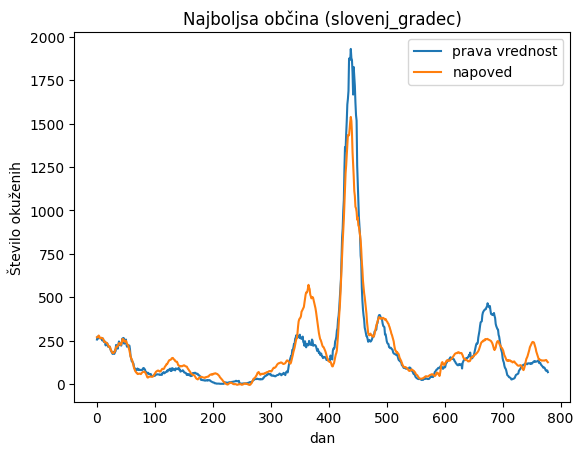

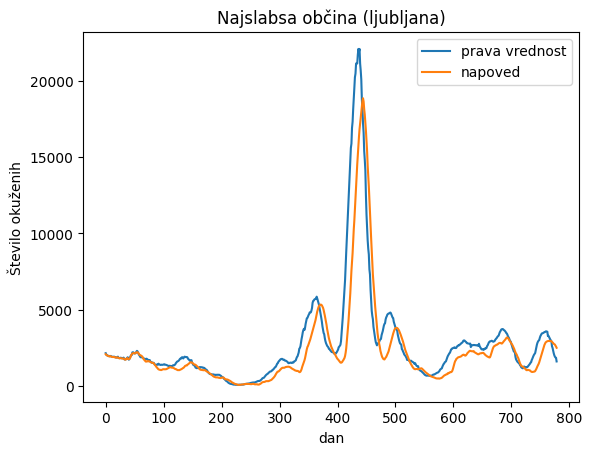

In [22]:
import matplotlib.pyplot as plt

for obcina, string in [(najboljsa, 'Najboljsa'), (najslabsa, 'Najslabsa')]:
        prave_vrednosti[obcina].plot(label='prava vrednost')
        napovedane[obcina].plot(label='napoved')
        plt.title(f'{string} občina ({obcina})')
        plt.legend()
        plt.xlabel('dan')
        plt.ylabel('Število okuženih')
        plt.savefig(f'./img/{string}.png')
        plt.show()



In [37]:
# graf povprečne napake v odvisnosti od časa
#


# graf primerjave
# za dan i me zanima realno stanje in napovedano stanje (prvi dan)
prave_vrednosti = pd.DataFrame( columns=MESTNE_OBCINE)
napovedane = [pd.DataFrame( columns=MESTNE_OBCINE)  for _ in range(7)]
for index, (ex, ans) in enumerate(zip(X, y)):
        prave_vrednosti.loc[len(prave_vrednosti)] = ans.numpy()[0]
        out = model(ex)
        for i in range(7):
           
            napovedane[i].loc[len(napovedane[i])] =out.detach().numpy()[i]
             



In [38]:
napovedane[0]

,ljubljana,maribor,kranj,koper,celje,novo_mesto,velenje,nova_gorica,krško,ptuj,murska_sobota,slovenj_gradec
0,2077.263184,1044.357178,534.946899,200.542969,447.715881,459.363556,506.756531,240.732635,206.407150,325.776672,281.926056,268.562714
1,2030.124512,1033.442505,515.443237,206.369476,443.772736,464.482178,494.772736,232.998489,231.554672,307.232849,281.593964,269.856598
2,2009.065186,1048.929810,507.456573,220.095169,443.934601,468.221527,504.652863,236.413177,251.707153,290.789612,287.553436,271.664337
3,1982.889526,1058.946045,495.219849,224.570633,451.345856,481.925446,509.389191,243.697891,271.019836,276.280548,290.573608,278.963837
4,1960.845459,1080.021362,480.535858,233.712265,450.069641,481.894592,518.196838,245.244659,290.885437,263.226990,290.928467,274.740326
...,...,...,...,...,...,...,...,...,...,...,...,...
774,2735.761719,1303.505371,705.321411,391.125885,531.030151,485.696899,357.377106,348.052734,406.485870,501.858917,224.301666,136.807175
775,2709.398438,1270.627319,707.304138,398.506775,514.698975,492.157410,349.332306,326.086121,401.159088,513.077332,230.027298,138.131180
776,2646.780273,1240.185547,704.299377,415.864960,495.542419,486.184540,340.310028,305.676880,400.458038,516.540588,227.263489,134.376511
777,2576.462891,1207.460938,694.843384,426.762695,480.994904,472.336487,325.607300,287.506500,394.997498,507.580383,227.967819,128.538773


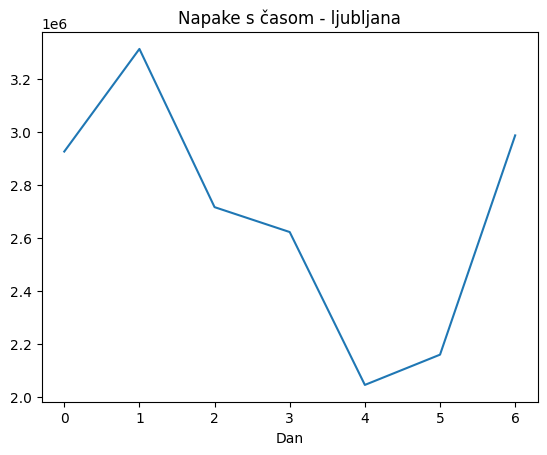

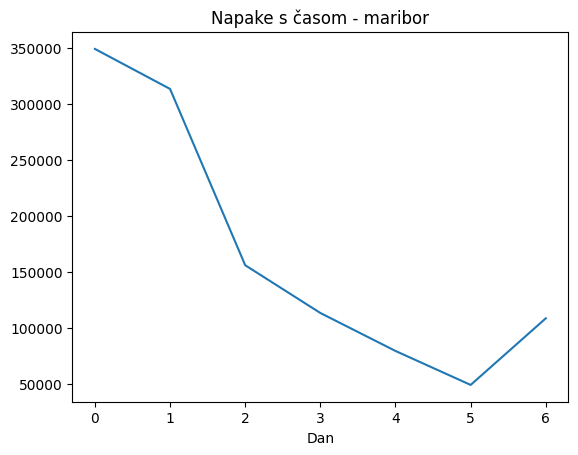

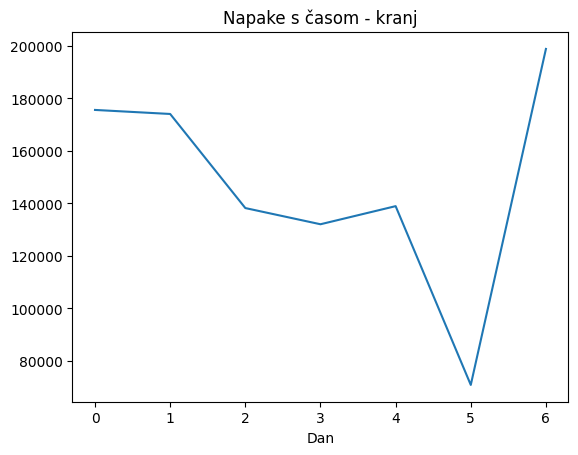

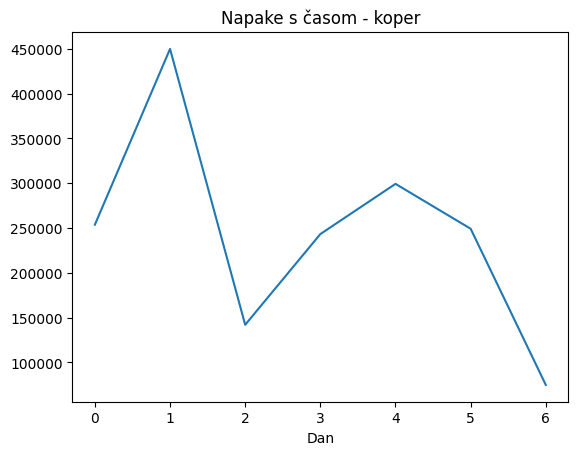

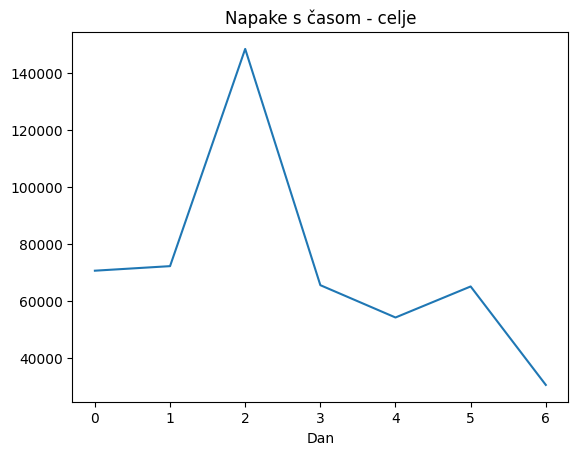

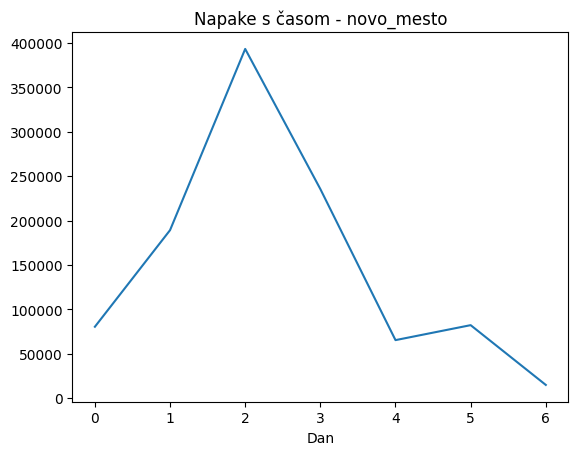

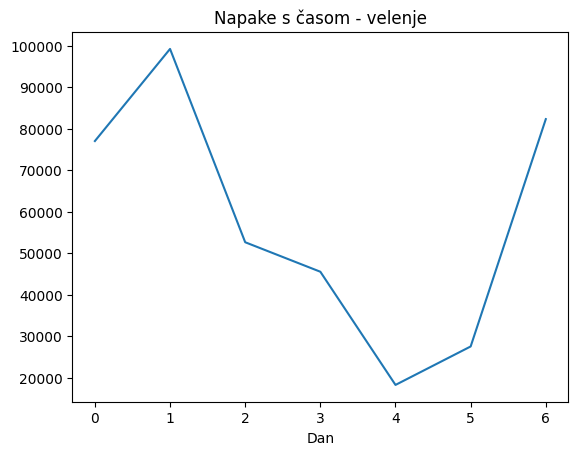

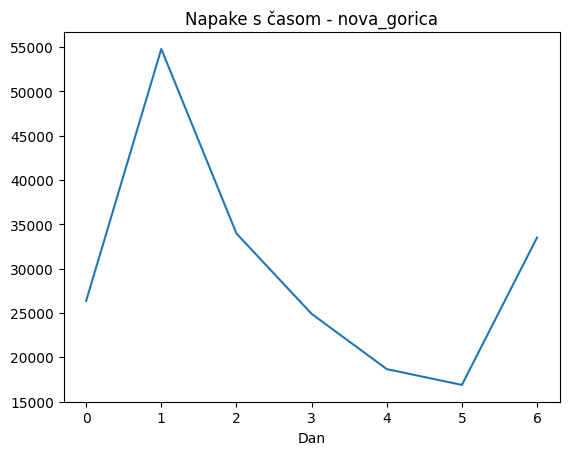

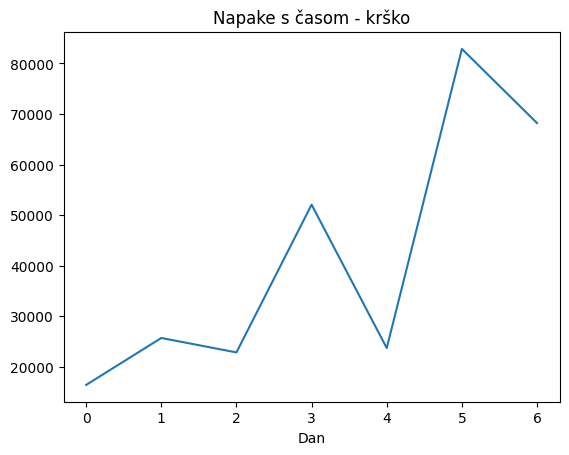

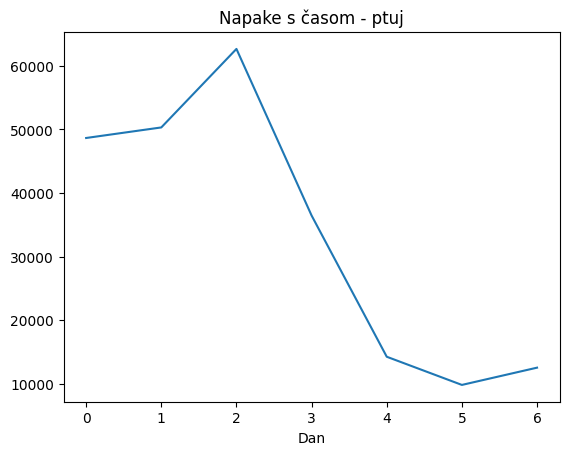

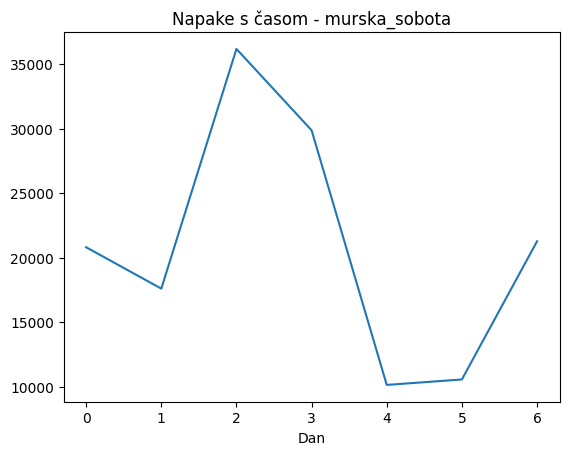

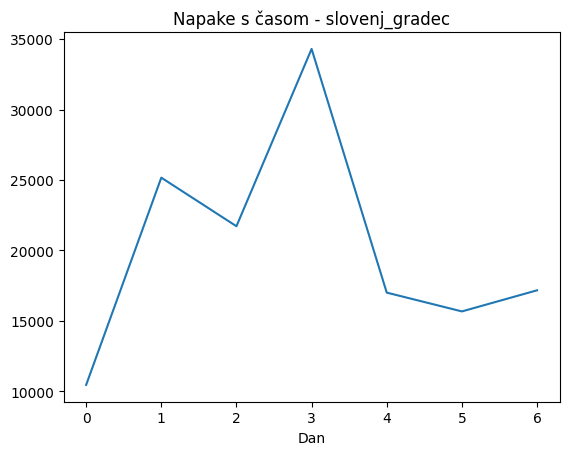

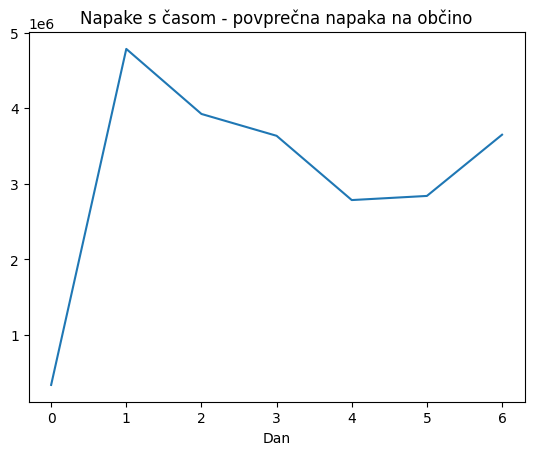

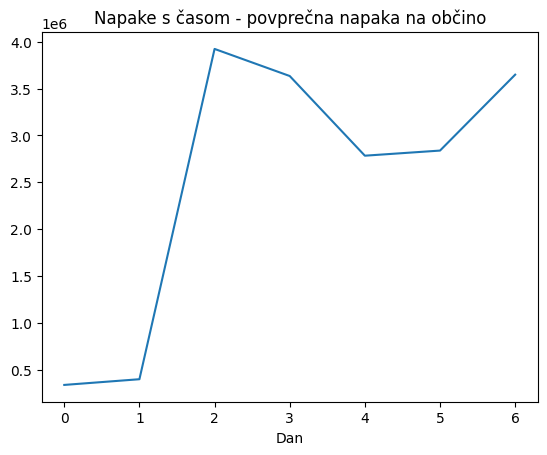

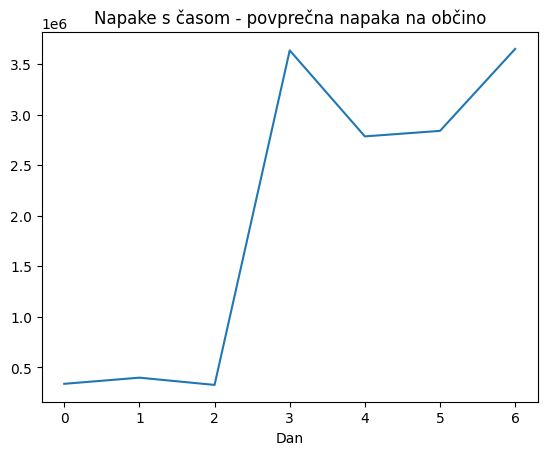

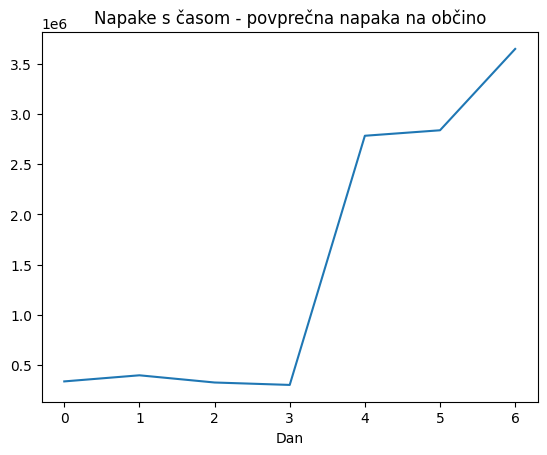

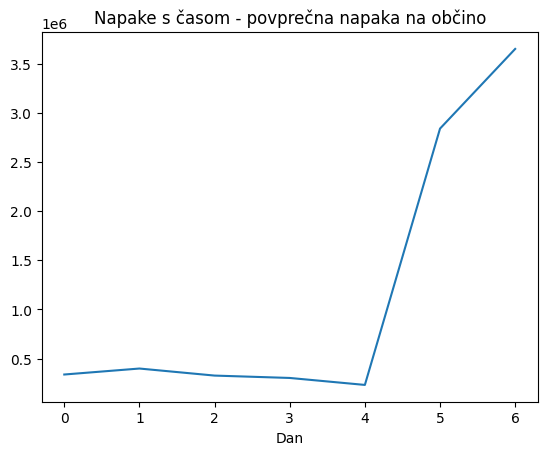

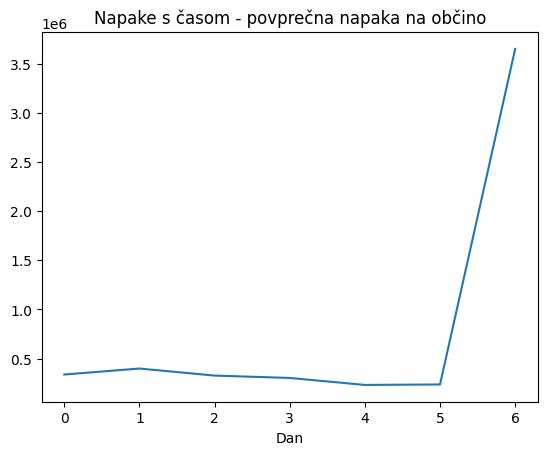

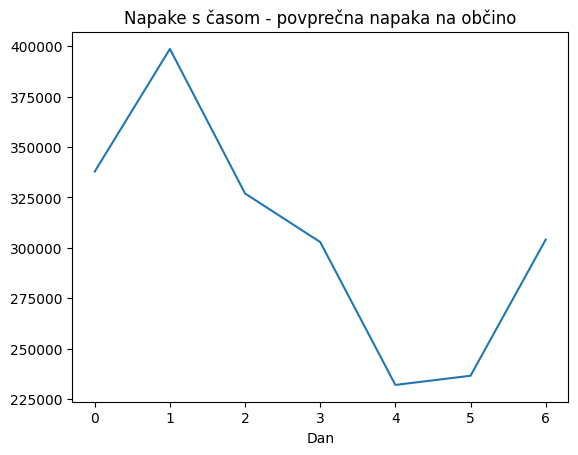

In [41]:
vse_napake = [0 for _ in range(7)]
for obcina in MESTNE_OBCINE:
      napake = []
      for i in range(7):
            napake.append(mean_squared_error(prave_vrednosti[obcina], napovedane[i][obcina]))
            vse_napake[i] += mean_squared_error(prave_vrednosti[obcina], napovedane[i][obcina])
      plt.plot([i for i in range(7)], napake)
      plt.title(f'Napake s časom - {obcina}')
      plt.xlabel('Dan')
      plt.savefig(f'./img/odvisnost_{obcina}')
      plt.show()

for i in range(7):
      vse_napake[i] /= len(MESTNE_OBCINE)
      plt.plot([i for i in range(7)], vse_napake)
      plt.title(f'Napake s časom - povprečna napaka na občino')
      plt.xlabel('Dan')
      plt.savefig(f'./img/odvisnost_vse')
      plt.show()